# Links del proyecto
- Repositorio de Github: [https://github.com/armandoBringas/NavegacionAutonoma_ProyectoFinal](https://github.com/armandoBringas/NavegacionAutonoma_ProyectoFinal)
- Video en YouTube: TBD



# Navegación Autónoma Proyecto Final

Este proyecto tiene como objetivo desarrollar un sistema de navegación autónoma utilizando clonación de comportamiento y datos de sensores. 
El repositorio está organizado de la siguiente manera:

## Estructura del Proyecto

```plaintext
NavegacionAutonoma_ProyectoFinal/
│
├── config/
│   └── environment.yml
│
├── data/
│   ├── train_images/
│   └── images.csv
│
├── models/
│   └── behavioral_cloning_training.keras
│
├── notebooks/
│   └── behavioral_cloning_training.ipynb
│
├── report/
│   
├── scripts/
│   ├── behavioral_cloning_and_sensors_driving.py
│   ├── capture_controller_input.py
│   └── create_report.py
│   
├── webots_worlds/
│   ├── city_traffic_2024_02_net/
│   ├── city_traffic_2024_01.wbt
│   └── city_traffic_2024_02.wbt
│
├── .gitignore
└── README.md
```

## Descripciones de Directorios

- **config/**: Contiene archivos de configuración.
  - **environment.yml**: Archivo de configuración del entorno para configurar dependencias.

- **data/**: Contiene archivos relacionados con los datos.
  - **train_images/**: Directorio para imágenes de entrenamiento.
  - **images.csv**: Archivo CSV que contiene metadatos de imágenes.

- **models/**: Contiene modelos entrenados.
  - **gear_fifth.keras**: Ejemplo de un archivo de modelo entrenado.

- **notebooks/**: Contiene cuadernos de Jupyter.
  - **behavioral_cloning_training.ipynb**: Cuaderno para entrenar el modelo de clonación de comportamiento.
  
- **report/**: Contiene script para generar el reporte final.

- **scripts/**: Contiene scripts de Python.
  - **behavioral_cloning_and_sensors_driving.py**: Script combinado para clonación de comportamiento y conducción con datos de sensores.
  - **capture_controller_input.py**: Script para capturar datos de entrada.
  - **create_report.py**: Script para crear informes.

- **webots_worlds/**: Contiene mundos de simulación de Webots.
- - **city_traffic_2024_02_nets/**: Directorio con las configuraciones de SUMO.
  - **city_traffic_2024_01.wbt**: Archivo del mundo de Webots para el escenario de tráfico de la ciudad 01.
  - **city_traffic_2024_02.wbt**: Archivo del mundo de Webots para el escenario de tráfico de la ciudad 02.

- **.gitignore**: Especifica qué archivos/carpetas ignorar en el control de versiones.
- **README.md**: Archivo de documentación que explica el proyecto.

## Instrucciones de Configuración

Para configurar el entorno, ejecute el siguiente comando:

```bash
conda env create -f config/environment.yml
```

Active el entorno:

```bash
conda activate your_environment_name
```

## Secuencia de Uso

### Captura de Datos de Entrada

Para capturar datos de entrada, ejecute:

```bash
python scripts/capture_controller_input.py
```

### Entrenamiento del Modelo

Para entrenar el modelo de clonación de comportamiento, ejecute el cuaderno de Jupyter:

```bash
jupyter notebook notebooks/behavioral_cloning_training.ipynb
```

### Conducción Usando el Modelo

Para conducir usando el modelo de clonación de comportamiento entrenado, ejecute:

```bash
python scripts/behavioral_cloning_and_sensors_driving.py
```


## Simulaciones de Webots

Para usar los mundos de simulación de Webots, abra los archivos `.wbt` ubicados en el directorio `webots_worlds/` con Webots.


# Código (.py): behavioral_cloning_and_sensors_driving.py

Contenido y descripción del código:

In [ ]:
# Importación de bibliotecas y módulos necesarios
import numpy as np  # NumPy se usa para operaciones numéricas
import cv2  # OpenCV para tareas de procesamiento de imágenes
import pygame  # Pygame para tareas de desarrollo de juegos y manejo de entradas de joystick

# Importación de clases necesarias desde los módulos controller y vehicle
from controller import Robot, Camera, GPS  # Clases Robot, Camera y GPS del módulo controller
from vehicle import Car, Driver  # Clases Car y Driver del módulo vehicle

# Importación de funciones y clases necesarias desde Keras
from keras.models import load_model  # Función para cargar un modelo preentrenado de Keras
from keras.optimizers import Adam  # Optimizador Adam para entrenar el modelo

# Constantes
THRESHOLD_DISTANCE_CAR = 6.5  # Distancia umbral para detección de coches en metros
CAR_SPEED = 30  # Velocidad en km/h cuando no se detecta ningún objeto o hay una distancia segura del coche
USE_CONTROLLER = False  # Opción para habilitar o deshabilitar el uso del controlador de videojuegos


class Controller:
    """
    La clase Controller es responsable de manejar las entradas del joystick si el flag USE_CONTROLLER está activado.
    Inicializa el joystick, obtiene el valor del eje y verifica si un botón está presionado.
    """

    DEAD_ZONE = 0.1  # La zona muerta es una pequeña área central del joystick que generalmente está alrededor
    # de la posición de reposo.

    def __init__(self):
        """
        Inicializa la clase Controller. Si USE_CONTROLLER está activado, inicializa pygame y el joystick.
        """
        if USE_CONTROLLER:  # Verificar si el flag USE_CONTROLLER está activado
            pygame.init()  # Inicializar todos los módulos importados de pygame
            pygame.joystick.init()  # Inicializar el módulo de joystick
            self.joystick = pygame.joystick.Joystick(0)  # Crear un nuevo objeto Joystick
            self.joystick.init()  # Inicializar el Joystick

    def get_axis(self, axis):
        """
        Retorna el valor del eje especificado si USE_CONTROLLER está activado.
        Si el valor absoluto del eje es menor que la DEAD_ZONE, retorna 0.
        Si USE_CONTROLLER está desactivado, retorna 0.

        Parámetros:
        axis (int): El eje del cual obtener el valor.

        Retorna:
        float: El valor del eje.
        """
        if USE_CONTROLLER:  # Verificar si el flag USE_CONTROLLER está activado
            value = self.joystick.get_axis(axis)  # Obtener la posición actual del eje dado
            return 0 if abs(value) < self.DEAD_ZONE else value  # Retornar 0 si el valor absoluto es
            # menor que la DEAD_ZONE
        return 0  # Si USE_CONTROLLER está desactivado, retornar 0

    def button_pressed(self, button):
        """
        Verifica si el botón especificado está presionado si USE_CONTROLLER está activado.
        Si USE_CONTROLLER está desactivado, retorna False.

        Parámetros:
        button (int): El botón a verificar si está presionado.

        Retorna:
        bool: True si el botón está presionado, False de otra manera.
        """
        if USE_CONTROLLER:  # Verificar si el flag USE_CONTROLLER está activado
            return self.joystick.get_button(button)  # Retornar True si el botón está presionado, de lo contrario False
        return False  # Si USE_CONTROLLER está desactivado, retornar False


class CarEngine:
    """
    La clase CarEngine es responsable de controlar los movimientos del coche y las interacciones con el entorno.
    Inicializa el coche, el conductor, la cámara, el lidar y la pantalla. También maneja la velocidad y el ángulo de
    dirección del coche.
    """

    MAX_ANGLE = 0.28  # Ángulo máximo de dirección

    def __init__(self):
        """
        Inicializa la clase CarEngine. Inicializa el coche, el conductor, la cámara, el lidar y la pantalla.
        """
        self.robot = Car()  # Inicializar el coche
        self.driver = Driver()  # Inicializar el conductor
        self.timestep = int(self.robot.getBasicTimeStep())  # Obtener el paso de tiempo básico del robot
        self.camera = self._initialize_device("camera")  # Inicializar la cámara
        self.front_camera = self._init_camera_recognition("Front Camera")  # Inicializar la cámara frontal
        # con reconocimiento
        self.gps = self._initialize_device("gps")  # Inicializar el GPS
        self.lidar = self._init_lidar("lidar")  # Inicializar el lidar
        self.display = self.robot.getDevice("display")  # Obtener el dispositivo de pantalla
        self.angle = 0.0  # Inicializar el ángulo de dirección
        self.speed = 25.0  # Inicializar la velocidad

    def _initialize_device(self, device_name):
        """
        Inicializa un dispositivo.

        Parámetros:
        device_name (str): El nombre del dispositivo a inicializar.

        Retorna:
        Device: El dispositivo inicializado.
        """
        device = self.robot.getDevice(device_name)  # Obtener el dispositivo
        device.enable(self.timestep)  # Habilitar el dispositivo
        return device

    def _init_camera_recognition(self, device_name):
        """
        Inicializa una cámara con reconocimiento.

        Parámetros:
        device_name (str): El nombre de la cámara a inicializar.

        Retorna:
        Camera: La cámara inicializada.
        """
        camera = self.robot.getDevice(device_name)  # Obtener la cámara
        camera.enable(self.timestep)  # Habilitar la cámara
        camera.recognitionEnable(self.timestep)  # Habilitar el reconocimiento en la cámara
        return camera

    def _init_lidar(self, device_name):
        """
        Inicializa un lidar.

        Parámetros:
        device_name (str): El nombre del lidar a inicializar.

        Retorna:
        Lidar: El lidar inicializado.
        """
        lidar = self.robot.getDevice(device_name)  # Obtener el lidar
        lidar.enable(self.timestep)  # Habilitar el lidar
        lidar.enablePointCloud()  # Habilitar la nube de puntos en el lidar
        return lidar

    def update_display(self):
        """
        Actualiza la pantalla con la velocidad actual y el ángulo de dirección.
        """
        speed = self.driver.getCurrentSpeed()  # Obtener la velocidad actual
        steering_angle = self.driver.getSteeringAngle()  # Obtener el ángulo de dirección actual
        print(f"Vehicle Speed: {speed:.2f} km/h, Steering Angle: {steering_angle:.5f} rad")  # Imprimir la
        # velocidad y el ángulo de dirección
        speed_label_str = "Speed: "  # Etiqueta de velocidad
        speed_value_str = f"{speed:.2f} km/h"  # Valor de velocidad
        steering_angle_label_str = "Steering Angle: "  # Etiqueta de ángulo de dirección
        steering_angle_value_str = f"{steering_angle:.5f} rad"  # Valor de ángulo de dirección
        self.display.setColor(0x000000)  # Establecer el color de la pantalla en negro
        self.display.fillRectangle(0, 0, self.display.getWidth(), self.display.getHeight())  # Llenar la
        # pantalla con el color
        aquamarine = 0x7FFFD4  # Color aguamarina
        white = 0xFFFFFF  # Color blanco
        self.display.setColor(aquamarine)  # Establecer el color de la pantalla en aguamarina
        self.display.drawText(speed_label_str, 5, 10)  # Dibujar la etiqueta de velocidad
        self.display.drawText(steering_angle_label_str, 5, 30)  # Dibujar la etiqueta de ángulo de dirección
        self.display.setColor(white)  # Establecer el color de la pantalla en blanco
        self.display.drawText(speed_value_str, 50, 10)  # Dibujar el valor de velocidad
        self.display.drawText(steering_angle_value_str, 100, 30)  # Dibujar el valor de ángulo de dirección

    def set_steering_angle(self, value):
        """
        Establece el ángulo de dirección. Si el valor absoluto de la entrada es menor que la zona muerta, establece el
        ángulo de dirección en 0.

        Parámetros:
        value (float): El valor para establecer el ángulo de dirección.
        """
        DEAD_ZONE = 0.06  # Zona muerta
        value = value if abs(value) > DEAD_ZONE else 0.0  # Si el valor absoluto de la entrada es menor que
        # la zona muerta, establecerlo en 0
        self.angle = self.MAX_ANGLE * value  # Establecer el ángulo de dirección

    def set_speed(self, kmh):
        """
        Establece la velocidad.

        Parámetros:
        kmh (float): La velocidad en km/h para establecer.
        """
        self.speed = kmh  # Establecer la velocidad
        self.driver.setCruisingSpeed(self.speed)  # Establecer la velocidad de crucero

    def update(self):
        """
        Actualiza la pantalla, el ángulo de dirección y la velocidad.
        """
        self.update_display()  # Actualizar la pantalla
        self.driver.setSteeringAngle(self.angle)  # Establecer el ángulo de dirección
        self.driver.setCruisingSpeed(self.speed)  # Establecer la velocidad de crucero

    def get_image(self):
        """
        Obtiene una imagen de la cámara, la redimensiona y la convierte al espacio de color BGR.

        Retorna:
        np.array: La imagen.
        """
        raw_image = self.camera.getImage()  # Obtener la imagen cruda de la cámara
        image = np.frombuffer(raw_image, np.uint8).reshape((self.camera.getHeight(), self.camera.getWidth(), 4))
        # Redimensionar la imagen cruda
        image = cv2.resize(image, (200, 66))  # Redimensionar la imagen
        image = image[35:, :, :]  # Recortar la imagen
        image = cv2.resize(image, (200, 66))  # Redimensionar la imagen
        image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)  # Convertir la imagen al espacio de color BGR
        return image

    def get_lid_ranges(self):
        """
        Obtiene los rangos del lidar, calcula el rango medio y detecta si se detecta un peatón o coche.

        Retorna:
        tuple: El rango medio, número de láseres, rango mínimo y detección.
        """
        range_image = self.lidar.getRangeImage()  # Obtener la imagen de rango del lidar
        ranges = [val for val in range_image if not np.isinf(val)]  # Obtener los rangos que no son infinitos
        num_lasers = len(ranges)  # Obtener el número de láseres
        mean_range = np.mean(ranges)  # Calcular el rango medio
        min_range = min(ranges) if ranges else float('inf')  # Obtener el rango mínimo si hay rangos, de lo
        # contrario establecerlo en infinito
        print(f'Num Lasers: {num_lasers}')  # Imprimir el número de láseres
        detection = None  # Inicializar la detección
        if num_lasers == 0:  # Si no hay láseres
            print("Detected: None")  # Imprimir que no se detecta nada
        elif num_lasers < 150:  # Si el número de láseres es menor que 150
            detection = "Pedestrian"  # Establecer la detección en peatón
            print("Detected: Pedestrian")  # Imprimir que se detecta un peatón
        else:  # Si el número de láseres no es menor que 150
            detection = "Car"  # Establecer la detección en coche
            print("Detected: Car")  # Imprimir que se detecta un coche
        return mean_range, num_lasers, min_range, detection  # Retornar el rango medio, número de láseres,
        # rango mínimo y detección


def main_loop(car, model, controller):
    """
    El bucle principal del programa. Obtiene una imagen del coche, predice el ángulo de dirección, establece el ángulo
    de dirección y la velocidad,y actualiza el coche. Si se detecta un peatón o coche, establece la velocidad en 0. Si
    se detecta un coche y el rango mínimo es menor que la distancia umbral, establece la velocidad en 0. Si no se detecta
    nada, establece la velocidad en la velocidad del coche. Si se presiona el botón del controlador, rompe el bucle.

    Parámetros:
    car (CarEngine): El coche.
    model (Model): El modelo.
    controller (Controller): El controlador.
    """
    try:
        TIMER = 30  # Temporizador
        COUNTER = 0  # Contador
        predicted_steering_angle = 0.0  # Ángulo de dirección predicho
        while car.robot.step() != -1:  # Mientras el robot esté funcionando
            if COUNTER == TIMER:  # Si el contador es igual al temporizador
                image = car.get_image()  # Obtener una imagen del coche
                preprocessed_image = np.array([image])  # Preprocesar la imagen
                predicted_steering_angle = model.predict(preprocessed_image)[0][0]  # Predecir el ángulo de dirección
                print(f"Predicted steering angle: {predicted_steering_angle}")  # Imprimir el ángulo de
                # dirección predicho
                COUNTER = 0  # Reiniciar el contador
                car.set_steering_angle(predicted_steering_angle)  # Establecer el ángulo de dirección
                dist, num_lasers, min_range, detection = car.get_lid_ranges()  # Obtener los rangos del lidar
                if detection == "Pedestrian":  # Si se detecta un peatón
                    car.set_speed(0)  # Establecer la velocidad en 0
                elif detection == "Car":  # Si se detecta un coche
                    if min_range < THRESHOLD_DISTANCE_CAR:  # Si el rango mínimo es menor que la distancia umbral
                        car.set_speed(0)  # Establecer la velocidad en 0
                    else:  # Si el rango mínimo no es menor que la distancia umbral
                        car.set_speed(CAR_SPEED)  # Establecer la velocidad en la velocidad del coche
                else:  # Si no se detecta nada
                    car.set_speed(CAR_SPEED)  # Establecer la velocidad en la velocidad del coche
                car.update()  # Actualizar el coche
                print(f"Vehicle Speed: {car.speed} km/h, Steering Angle: {car.angle} rad")  # Imprimir la velocidad
                # y el ángulo de dirección
            COUNTER += 1  # Incrementar el contador
            if USE_CONTROLLER:  # Si se usa el controlador
                pygame.event.pump()  # Bombear la cola de eventos
                if controller.button_pressed(0):  # Si se presiona el botón del controlador
                    break  # Romper el bucle
    finally:
        if USE_CONTROLLER:  # Si se usa el controlador
            pygame.quit()  # Salir de pygame
        print("Exiting the main loop.")  # Imprimir que se está saliendo del bucle principal


if __name__ == "__main__":
    car = CarEngine()  # Inicializar el coche
    controller = Controller()  # Inicializar el controlador
    model = load_model('../models/behavioral_cloning.keras')  # Cargar el modelo
    model.compile(Adam(learning_rate=0.001), loss='mse')  # Compilar el modelo
    main_loop(car, model, controller)  # Ejecutar el bucle principal


# Código (.py): capture_controller_input.py

Contenido y descripción del código:

In [ ]:
# Bibliotecas para interacciones con el sistema operativo y operaciones de archivos CSV
import os
import csv

# Biblioteca para operaciones de fecha y hora
from datetime import datetime

# Bibliotecas para operaciones numéricas y procesamiento de imágenes
import numpy as np
import cv2

# Biblioteca para desarrollo de juegos y manejo de entradas del joystick
import pygame

# Bibliotecas para control de robots y vehículos
from controller import Robot, Camera, GPS
from vehicle import Car, Driver


class FileHandler:
    """
    Una clase utilizada para manejar operaciones de archivos como crear directorios,
    escribir en archivos CSV y guardar imágenes.
    """

    def __init__(self, folder="train_images", csv_file="images.csv", save_images=False):
        """
        Inicializar la clase FileHandler.

        Parámetros:
        folder (str): El nombre de la carpeta donde se guardarán las imágenes.
        csv_file (str): El nombre del archivo CSV donde se guardarán los nombres
                        de las imágenes y los ángulos de dirección.
        save_images (bool): Una bandera que indica si se deben guardar las imágenes o no.
        """
        self.folder = folder  # El nombre de la carpeta donde se guardarán las imágenes.
        self.csv_file = csv_file  # El nombre del archivo CSV donde se guardarán los nombres
        # de las imágenes y los ángulos de dirección.
        self.save_images = save_images  # Una bandera que indica si se deben guardar las imágenes o no.
        self._directory_exists()  # Verificar si el directorio existe, si no, crearlo.
        self.last_row = self._get_last_row()  # Obtener el último número de fila del archivo CSV.
        self.pic_num = 0 if self.last_row == 0 else self.last_row - 1
        # Establecer el número de imagen en 0 si el último número de fila es 0,
        # de lo contrario, establecerlo en el último número de fila menos 1.
        self.csv_writer = self._csv_writer()  # Inicializar el escritor de CSV.
        self.csv_file_handler = open(self.csv_file, mode='a', newline='') if self.save_images else None
        # Abrir el manejador de archivos CSV en modo de adición si save_images es True,
        # de lo contrario, establecerlo en None.
        self.last_image = None  # Inicializar la última imagen en None.

    def _directory_exists(self):
        """
        Verificar si el directorio existe, si no, crearlo.
        """
        if self.save_images and not os.path.exists(self.folder):
            os.makedirs(self.folder)

    def _get_last_row(self):
        """
        Obtener el último número de fila del archivo CSV.

        Retorna:
        int: El último número de fila.
        """
        if not os.path.isfile(self.csv_file):
            return 0  # Si el archivo CSV no existe, retornar 0.
        with open(self.csv_file, mode='r') as f:  # Abrir el archivo CSV en modo de lectura.
            last_row = 0  # Inicializar el último número de fila en 0.
            reader = csv.reader(f)  # Crear un lector de CSV para el archivo.
            for last_row, _ in enumerate(reader, 1):
                pass  # Enumerar sobre las filas en el archivo CSV, comenzando la cuenta desde 1.
            return last_row  # Después de recorrer todas las filas, retornar el último número de fila.

    def _csv_writer(self):
        """
        Inicializar el escritor de CSV.

        Retorna:
        csv.writer: El escritor de CSV.
        """
        if not self.save_images:
            return None  # Si save_images es False, retornar None.
        csv_file = open(self.csv_file, mode='a', newline='')  # Abrir el archivo CSV en modo de adición.
        csv_writer = csv.writer(csv_file)  # Crear un escritor de CSV para el archivo.
        if not self._csv_exist_and_content():
            csv_writer.writerow(["Image Name", "Steering Angle"])
            # Si el archivo CSV no existe o no tiene contenido, escribir la fila de encabezado en el archivo CSV.
        return csv_writer  # Retornar el escritor de CSV.

    def _csv_exist_and_content(self):
        """
        Verificar si el archivo CSV existe y tiene contenido.

        Retorna:
        bool: True si el archivo CSV existe y tiene contenido, False en caso contrario.
        """
        return os.path.isfile(self.csv_file) and os.path.getsize(self.csv_file) > 0

    def write_path_image(self, steering_angle):
        """
        Escribir la ruta de la imagen y el ángulo de dirección en el archivo CSV.

        Parámetros:
        steering_angle (float): El ángulo de dirección.
        """
        current_datetime = datetime.now().strftime("%Y-%m-%d_%H-%M")
        # Obtener la fecha y hora actuales y formatearlas como "YYYY-MM-DD_HH-MM".
        file_name = os.path.join(self.folder, f"M-{current_datetime}-{self.pic_num}.png")
        # Crear el nombre del archivo uniendo el nombre de la carpeta, la fecha y hora formateadas,
        # y el número de imagen, y agregando la extensión ".png".
        if file_name != self.last_image:
            self.csv_writer.writerow([file_name, steering_angle])
            # Escribir el nombre del archivo y el ángulo de dirección en el archivo CSV.
            print(f"Image saved: {file_name}, Steering angle: {steering_angle}")
            # Imprimir un mensaje indicando que la imagen ha sido guardada y mostrando el nombre del archivo
            # y el ángulo de dirección.
            self.last_image = file_name  # Establecer el nombre del archivo de la última imagen
            # en el nombre del archivo actual.
            self.pic_num += 1  # Incrementar el número de imagen en 1.

    def flush_and_close(self):
        """
        Vaciar y cerrar el manejador de archivos CSV.
        """
        if self.save_images:
            self.csv_file_handler.flush()
            self.csv_file_handler.close()


class Controller:
    """
    Una clase utilizada para manejar las entradas del joystick.
    """

    DEAD_ZONE = 0.05

    def __init__(self):
        """
        Inicializar la clase Controller.
        """
        pygame.init()
        pygame.joystick.init()
        self.joystick = pygame.joystick.Joystick(0)
        self.joystick.init()

    def get_axis(self, axis):
        """
        Obtener el valor del eje especificado.

        Parámetros:
        axis (int): El número del eje.

        Retorna:
        float: El valor del eje. Si el valor absoluto es menor que la zona muerta, retorna 0.0.
        """
        value = self.joystick.get_axis(axis)
        return 0.0 if abs(value) < self.DEAD_ZONE else value

    def button_pressed(self, button):
        """
        Verificar si el botón especificado está presionado.

        Parámetros:
        button (int): El número del botón.

        Retorna:
        bool: True si el botón está presionado, False en caso contrario.
        """
        return self.joystick.get_button(button)


class CarEngine:
    """
    Una clase utilizada para controlar los movimientos del coche y mostrar la velocidad y el ángulo de dirección.
    """

    def __init__(self):
        """
        Inicializar la clase CarEngine.
        """
        self.robot = Car()  # Crear una instancia de la clase Car para controlar los movimientos del coche.
        self.driver = Driver()  # Crear una instancia de la clase Driver para controlar las acciones del conductor.
        self.timestep = int(self.robot.getBasicTimeStep())
        # Obtener el paso de tiempo básico del robot, que es el intervalo de tiempo entre dos pasos
        # consecutivos de control.
        self.camera = self._initialize_device("camera")  # Inicializar el dispositivo de cámara para capturar imágenes.
        self.gps = self._initialize_device("gps")  # Inicializar el dispositivo GPS para obtener las coordenadas GPS.
        self.display = self.robot.getDevice("display")  # Obtener el dispositivo de visualización para mostrar la
        # velocidad y el ángulo de dirección.
        self.angle = 0.0  # Establecer el ángulo de dirección inicial en 0.0.
        self.speed = 30.0  # Establecer la velocidad inicial en 30.0 km/h.
        self.MAX_STEERING = 1.0  # Establecer el ángulo de dirección máximo en 1.0.

    def _initialize_device(self, device_name):
        """
        Inicializar el dispositivo especificado.

        Parámetros:
        device_name (str): El nombre del dispositivo.

        Retorna:
        Device: El dispositivo inicializado.
        """
        device = self.robot.getDevice(device_name)
        device.enable(self.timestep)
        return device

    def set_steering_angle(self, joystick_value):
        """
        Establecer el ángulo de dirección basado en el valor del joystick.

        Parámetros:
        joystick_value (float): El valor del joystick.
        """
        self.angle = self.MAX_STEERING * joystick_value

    def set_speed(self, kmh):
        """
        Establecer la velocidad del coche.

        Parámetros:
        kmh (float): La velocidad en kilómetros por hora.
        """
        self.speed = kmh

    def update_display(self):
        """
        Actualizar la pantalla con la velocidad actual y el ángulo de dirección.
        """
        speed = self.driver.getCurrentSpeed()  # Obtener la velocidad actual del conductor.
        steering_angle = self.driver.getSteeringAngle()
        # Obtener el ángulo de dirección actual del conductor.

        speed_label_str = "Speed: "  # Definir la cadena de etiqueta de velocidad.
        speed_value_str = f"{speed:.2f} km/h"  # Formatear la cadena de valor de velocidad con la velocidad actual.
        steering_angle_label_str = "Steering Angle: "
        # Definir la cadena de etiqueta del ángulo de dirección.
        steering_angle_value_str = f"{steering_angle:.5f} rad"
        # Formatear la cadena de valor del ángulo de dirección con el ángulo de dirección actual.

        self.display.setColor(0x000000)  # Establecer el color de la pantalla a negro.
        self.display.fillRectangle(0, 0, self.display.getWidth(), self.display.getHeight())
        # Rellenar el rectángulo de la pantalla con el color actual.

        aquamarine = 0x7FFFD4  # Definir el color aguamarina.
        white = 0xFFFFFF  # Definir el color blanco.

        self.display.setColor(aquamarine)  # Establecer el color de la pantalla a aguamarina.
        self.display.drawText(speed_label_str, 5, 10)
        # Dibujar la cadena de etiqueta de velocidad en la posición especificada.
        self.display.drawText(steering_angle_label_str, 5, 30)
        # Dibujar la cadena de etiqueta del ángulo de dirección en la posición especificada.

        self.display.setColor(white)  # Establecer el color de la pantalla a blanco.
        self.display.drawText(speed_value_str, 50, 10)
        # Dibujar la cadena de valor de velocidad en la posición especificada.
        self.display.drawText(steering_angle_value_str, 100, 30)
        # Dibujar la cadena de valor del ángulo de dirección en la posición especificada.

    def update(self):
        """
        Actualizar la pantalla y establecer el ángulo de dirección y la velocidad de crucero.
        """
        self.update_display()
        self.driver.setSteeringAngle(self.angle)
        self.driver.setCruisingSpeed(self.speed)

    def get_image(self):
        """
        Obtener la imagen actual de la cámara.

        Retorna:
        np.array: La imagen como un array de numpy.
        """
        raw_image = self.camera.getImage()  # Obtener la imagen actual de la cámara como una imagen sin procesar.
        return np.frombuffer(raw_image, np.uint8).reshape(
            (self.camera.getHeight(), self.camera.getWidth(), 4)
        )
        # Convertir la imagen sin procesar a un array de numpy con la forma correcta y retornarla.


def main_loop(car, controller, image_saver):
    """
    El bucle principal del programa. Maneja los movimientos del coche en función de las entradas del controlador
    y guarda imágenes si es necesario.

    Parámetros:
    car (CarEngine): El objeto motor del coche que controla los movimientos del coche
                     y muestra la velocidad y el ángulo de dirección.
    controller (Controller): El objeto controlador que maneja las entradas del joystick.
    image_saver (FileHandler): El objeto manejador de archivos que maneja las operaciones de archivos
                               como crear directorios, escribir en archivos CSV y guardar imágenes.

    La función se ejecuta en un bucle hasta que se presiona el botón 0 en el controlador. En cada iteración del bucle,
    procesa la cola de eventos de pygame, verifica si se presiona el botón 0 y, de ser así, rompe el bucle.
    Si el atributo save_images del objeto image_saver es True y el contador de pasos es mayor o igual a steps_per_second,
    escribe la ruta de la imagen y el ángulo de dirección en el archivo CSV y guarda la imagen. Luego, reinicia el contador
    de pasos a 0. Obtiene los valores de los ejes 0 y 1 del controlador, establece el ángulo de dirección del coche
    en función del valor del eje 0 y actualiza el coche. Después del bucle, vacía y cierra el manejador de archivos CSV
    y cierra pygame.
    """
    steps_per_second = 5  # Definir el número de pasos por segundo.
    step_counter = 0  # Inicializar el contador de pasos en 0.
    try:
        while car.robot.step() != -1:
            pygame.event.pump()  # Procesar eventos de pygame.

            if controller.button_pressed(0):  # Si se presiona el botón 0, romper el bucle.
                break

            step_counter += 1  # Incrementar el contador de pasos en 1.
            if image_saver.save_images and (step_counter >= steps_per_second):
                image_saver.write_path_image(axis_steering)
                car.camera.saveImage(image_saver.last_image, 1)
                # Guardar la imagen.
                step_counter = 0  # Reiniciar el contador de pasos.

            axis_steering = controller.get_axis(0)  # Obtener el valor del eje 0.
            axis_speed = controller.get_axis(1)  # Obtener el valor del eje 1.

            car.set_steering_angle(axis_steering)  # Establecer el ángulo de dirección del coche.
            car.update()  # Actualizar el coche.

    finally:
        image_saver.flush_and_close()  # Vaciar y cerrar el manejador de archivos CSV.
        pygame.quit()  # Cerrar pygame.


if __name__ == "__main__":
    car = CarEngine()
    # Crear una instancia de la clase CarEngine. Esta clase se utiliza para controlar los movimientos del coche
    # y mostrar la velocidad y el ángulo de dirección.

    controller = Controller()
    # Crear una instancia de la clase Controller. Esta clase se utiliza para manejar las entradas del joystick.

    image_saver = FileHandler()
    # Crear una instancia de la clase FileHandler. Esta clase se utiliza para manejar operaciones de archivos
    # como crear directorios, escribir en archivos CSV y guardar imágenes.

    main_loop(car, controller, image_saver)
    # Llamar al bucle principal del programa con el coche, el controlador y el manejador de archivos como argumentos.
    # El bucle principal maneja los movimientos del coche en función de las entradas del controlador
    # y guarda imágenes si es necesario.


# Libreta (.ipynb): behavioral_cloning_training.ipynb

# Entrenamiendo de Red Neuronal Convolucional (NVIDIA Model) para Clonar Comportamiento de Conducción

## **Librerías e instalaciones requeridas**

---

In [1]:
import os

# Bibliotecas para manipulación y análisis de datos
import numpy as np
import pandas as pd

# Bibliotecas para procesamiento de imágenes
import cv2

# Bibliotecas para visualización de datos
import matplotlib.pyplot as plt

# Bibliotecas para aprendizaje automático y preprocesamiento de datos
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Bibliotecas para aprendizaje profundo
from keras.optimizers import Adam
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Lambda
import tensorflow as tf

# Biblioteca para generar números aleatorios
import random

In [2]:
# Check TensorFlow version to ensure compatibility
print("TensorFlow version:", tf.__version__)

# List all available physical devices (including GPUs)
physical_devices = tf.config.list_physical_devices('GPU')
print("Physical GPUs:", physical_devices)

# If a GPU is available, print its details
if physical_devices:
    for gpu in physical_devices:
        print("Device:", gpu)
        details = tf.config.experimental.get_device_details(gpu)
        print("Name:", details.get('device_name'))
        print("Compute capability:", details.get('compute_capability'))
else:
    print("No GPU devices found.")

TensorFlow version: 2.10.1
Physical GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Name: NVIDIA GeForce RTX 4070 Laptop GPU
Compute capability: (8, 9)


In [3]:
# Configuración del tamaño para el procesamiento de imágenes
# Posibles parámetros para filtros
SIZE = (200,66)

## **Cargamos nuestro Dataset**

---

In [4]:
# Se espera que el archivo 'images.csv' esté libre de errores y contenga aproximadamente 3 vueltas de datos.
dataset = pd.read_csv('../data/images.csv')

# Mostrar el DataFrame
dataset


,Image Name,Steering Angle
0,train_images\M-2024-06-21_23-17-0.png,0.000000
1,train_images\M-2024-06-21_23-17-1.png,0.000000
2,train_images\M-2024-06-21_23-17-2.png,0.000000
3,train_images\M-2024-06-21_23-17-3.png,0.000000
4,train_images\M-2024-06-21_23-17-4.png,0.000000
...,...,...
19079,train_images\M-2024-06-22_00-03-19079.png,0.058807
19080,train_images\M-2024-06-22_00-03-19080.png,0.058807
19081,train_images\M-2024-06-22_00-03-19081.png,0.000000
19082,train_images\M-2024-06-22_00-03-19082.png,0.000000


## **Análisis y Preprocesamientos de los Datos**

___

In [5]:
# Mostrar la descripción estadística del conjunto de datos
dataset.describe()

,Steering Angle
count,19084.000000
mean,-0.062673
std,0.220761
min,-0.741180
25%,-0.200012
50%,0.000000
75%,0.000000
max,0.999969


In [6]:
# Extraer la columna 'Image Name' del conjunto de datos y almacenarla en 'paths'
paths = dataset['Image Name']
base_directory = '../data/'
paths = paths.apply(lambda x: os.path.join(base_directory, x))

# Imprimir el número total de rutas de imágenes
print(len(paths))

# Extraer la columna 'Steering Angle' del conjunto de datos y almacenarla en 'angles'
angles = dataset["Steering Angle"]

19084


In [7]:
def img_show(ruta, size=False, title=''):
    """
    Función para mostrar una imagen con redimensionamiento opcional.

    Parámetros:
    ruta (str): Ruta al archivo de imagen.
    size (bool): Si es True, la imagen se redimensiona a las dimensiones especificadas en SIZE. Por defecto es False.
    title (str): Título para la imagen. Por defecto es una cadena vacía.

    Retorna:
    Ninguno
    """
    # Leer el archivo de imagen de la ruta especificada
    img = cv2.imread(ruta)
    
    # Recortar la imagen para eliminar los primeros 35 píxeles
    img = img[35:,:,:]
    
    # Redimensionar la imagen si el parámetro size es True
    img = cv2.resize(img, SIZE) if size == True else img
    
    # Convertir la imagen de espacio de color BGR a RGB
    RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Crear una nueva figura para mostrar la imagen
    fig = plt.figure(figsize=(4,5))
    
    # Añadir un subplot a la figura
    ax1 = fig.add_subplot(111)
    
    # Establecer el título para el subplot
    ax1.set_title(title)
    
    # Mostrar la imagen en el subplot
    ax1.imshow(RGB_img)

../data/train_images\M-2024-06-21_23-25-6324.png


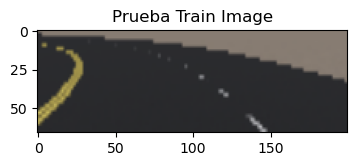

In [8]:
# Generar un índice aleatorio dentro del rango del número de rutas
index = random.randrange(0, len(paths))

# Imprimir la ruta en el índice generado aleatoriamente
print(paths[index])

# Mostrar la imagen en el índice generado aleatoriamente con el título 'Prueba Train Image' y redimensionada según SIZE
img_show(paths[index], title='Prueba Train Image', size=True)

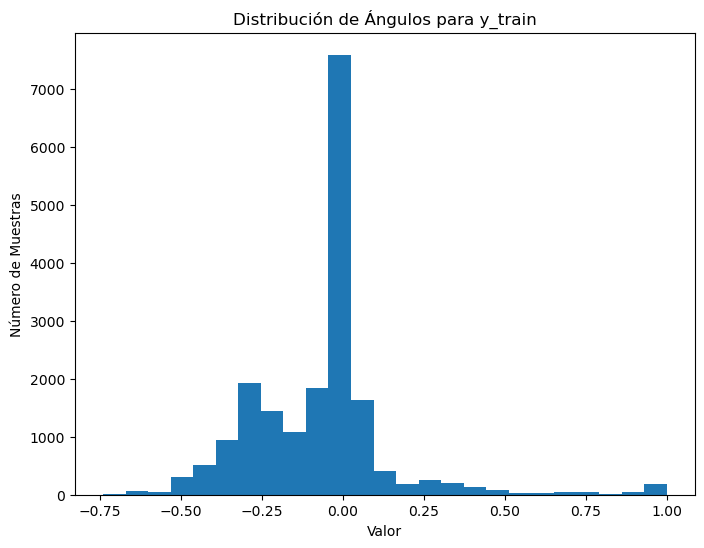

In [9]:
# Crear una nueva figura con el tamaño especificado
plt.figure(figsize=(8,6))

# Graficar un histograma de los datos de 'angles' con 25 bins
plt.hist(angles, bins=25)

# Establecer el título del gráfico
plt.title('Distribución de Ángulos para y_train')

# Establecer la etiqueta para el eje x
plt.xlabel("Valor")

# Establecer la etiqueta para el eje y
plt.ylabel("Número de Muestras")

# Mostrar el gráfico
plt.show()

## **Datos de Entrenamiento y Prueba**

___

In [10]:
# Función para cargar imágenes en una variable
def upload_dataset(path_list):
    """
    Función para cargar imágenes de una lista de rutas y devolverlas como una lista.

    Parámetros:
    path_list (list): Lista de rutas a los archivos de imagen.

    Retorna:
    output_list (list): Lista de imágenes cargadas y procesadas.
    """
    output_list = []
    for path in path_list:
        # Cargar la imagen en formato BGR
        img = cv2.imread(path)

        # Recortar la imagen para eliminar los primeros 35 píxeles
        img = img[35:,:,:]

        # Redimensionar la imagen según la variable global SIZE
        img = cv2.resize(img, SIZE)

        # Añadir la imagen procesada a la lista de salida
        output_list.append(img)
    return output_list

# Cargar las imágenes en X_train
X_train = np.array(upload_dataset(paths))

# Dividir el conjunto de datos en conjuntos de entrenamiento y prueba, con un tamaño de prueba del 10%
X_train, X_test, y_train, y_test = train_test_split(X_train, angles, test_size=0.1)

# Imprimir las formas de los conjuntos de entrenamiento y prueba
print('Formas del entrenamiento (Train)', X_train.shape, y_train.shape)
print('Formas del prueba (Test)', X_test.shape, y_test.shape)


Formas del entrenamiento (Train) (17175, 66, 200, 3) (17175,)
Formas del prueba (Test) (1909, 66, 200, 3) (1909,)


In [11]:
# Barajar los datos de entrenamiento para asegurar que el orden de los datos no afecte el proceso de aprendizaje
X_train, y_train = shuffle(X_train, y_train)

# Imprimir la forma de los datos de entrenamiento excluyendo la dimensión del tamaño del lote
# Esto es útil para confirmar las dimensiones de los datos que recibirá el modelo
print(X_train.shape[1:])

(66, 200, 3)


## **Modelo de Red Neuronal - NVIDIA Model**

___

In [12]:
# Inicializar un modelo Secuencial
model = Sequential()

# Añadir una capa Lambda para normalizar las imágenes de entrada a [-1,1] (suponiendo que las imágenes de entrada están escaladas a [0,255])
model.add(Lambda(lambda x: (x/127.5) - 1.0, input_shape=(66, 200, 3)))

# Añadir la primera capa de Convolución con 24 filtros de tamaño 5x5, función de activación ReLU y paso de 2
model.add(Conv2D(filters= 24, kernel_size=(5,5), activation='relu', strides=(2,2)))

# Añadir la segunda capa de Convolución con 36 filtros de tamaño 5x5, función de activación ReLU y paso de 2
model.add(Conv2D(filters= 36, kernel_size=(5,5), activation='relu', strides=(2,2)))

# Añadir la tercera capa de Convolución con 48 filtros de tamaño 5x5, función de activación ReLU y paso de 2
model.add(Conv2D(filters= 48, kernel_size=(5,5), activation='relu', strides=(2,2)))

# Añadir la cuarta capa de Convolución con 64 filtros de tamaño 3x3, función de activación ReLU
model.add(Conv2D(filters= 64, kernel_size=(3,3), activation='relu'))

# Añadir la quinta capa de Convolución con 64 filtros de tamaño 3x3, función de activación ReLU
model.add(Conv2D(filters= 64, kernel_size=(3,3), activation='relu'))

# Añadir una capa de Dropout para evitar el sobreajuste, desactiva el 50% de las neuronas
model.add(Dropout(0.5))

# Aplanar la salida del tensor de la capa anterior
model.add(Flatten())

# Añadir una capa Densa con 100 neuronas y función de activación ReLU
model.add(Dense(units= 100, activation= 'relu'))

# Añadir una capa Densa con 50 neuronas y función de activación ReLU
model.add(Dense(units= 50, activation= 'relu'))

# Añadir una capa Densa con 10 neuronas y función de activación ReLU
model.add(Dense(units= 10, activation= 'relu'))

# Añadir una capa Densa con 1 neurona y función de activación tanh (capa de salida)
model.add(Dense(units= 1, activation= 'tanh'))

# Compilar el modelo con el optimizador Adam y la función de pérdida de error cuadrático medio
model.compile(Adam(learning_rate= 0.001), loss='mse')

# Imprimir el resumen del modelo
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 66, 200, 3)        0         
                                                                 
 conv2d (Conv2D)             (None, 31, 98, 24)        1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 20, 64)         27712     
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 18, 64)         36928     
                                                                 
 dropout (Dropout)           (None, 1, 18, 64)         0

## **Entrenamiento del Modelo y Validación**

___

In [13]:
# Entrenar el modelo con los datos de entrenamiento
# Parámetros:
# X_train: datos de entrada para el entrenamiento
# y_train: datos de salida objetivo para el entrenamiento
# validation_split: fracción de los datos de entrenamiento que se usará como datos de validación
# epochs: número de veces que el algoritmo de aprendizaje recorrerá todo el conjunto de datos de entrenamiento
# batch_size: número de muestras a procesar antes de actualizar los parámetros internos del modelo
# verbose: modo de verbosidad, 1 = mostrar barra de progreso, 0 = silencioso
# shuffle: si se deben barajar los datos de entrenamiento antes de cada época
history = model.fit(
    X_train, y_train, validation_split=0.2, 
    epochs=20, batch_size=300, verbose=1, shuffle=True 
)

Epoch 1/20
46/46 [==============================] - 8s 56ms/step - loss: 0.0462 - val_loss: 0.0249
Epoch 2/20
46/46 [==============================] - 1s 29ms/step - loss: 0.0214 - val_loss: 0.0209
Epoch 3/20
46/46 [==============================] - 1s 29ms/step - loss: 0.0177 - val_loss: 0.0175
Epoch 4/20
46/46 [==============================] - 1s 28ms/step - loss: 0.0152 - val_loss: 0.0152
Epoch 5/20
46/46 [==============================] - 1s 28ms/step - loss: 0.0131 - val_loss: 0.0130
Epoch 6/20
46/46 [==============================] - 1s 27ms/step - loss: 0.0118 - val_loss: 0.0118
Epoch 7/20
46/46 [==============================] - 1s 28ms/step - loss: 0.0111 - val_loss: 0.0110
Epoch 8/20
46/46 [==============================] - 1s 28ms/step - loss: 0.0104 - val_loss: 0.0105
Epoch 9/20
46/46 [==============================] - 1s 29ms/step - loss: 0.0100 - val_loss: 0.0094
Epoch 10/20
46/46 [==============================] - 1s 28ms/step - loss: 0.0091 - val_loss: 0.0096
Epoch 11/

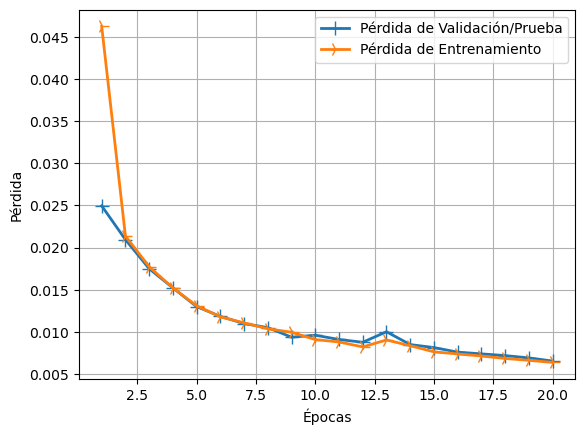

In [14]:
# Extraer el historial del proceso de entrenamiento del modelo
history_dict = history.history

# Extraer los valores de pérdida del historial
loss_values = history_dict['loss']

# Extraer los valores de pérdida de validación del historial
val_loss_values = history_dict['val_loss']

# Crear un rango de épocas desde 1 hasta el número de valores de pérdida más 1
epochs = range(1, len(loss_values) + 1)

# Graficar los valores de pérdida de validación contra las épocas
line1 = plt.plot(epochs, val_loss_values, label='Pérdida de Validación/Prueba')

# Graficar los valores de pérdida de entrenamiento contra las épocas
line2 = plt.plot(epochs, loss_values, label='Pérdida de Entrenamiento') 

# Establecer las propiedades para la línea de pérdida de validación
plt.setp(line1, linewidth=2.0, marker='+', markersize=10.0)

# Establecer las propiedades para la línea de pérdida de entrenamiento
plt.setp(line2, linewidth=2.0, marker='4', markersize=10.0)

# Establecer la etiqueta para el eje x
plt.xlabel('Épocas')

# Establecer la etiqueta para el eje y
plt.ylabel('Pérdida')

# Habilitar la cuadrícula en el gráfico
plt.grid(True)

# Añadir una leyenda al gráfico
plt.legend()

# Mostrar el gráfico
plt.show()


In [15]:
# Guardar el modelo entrenado
model.save("../models/behavioral_cloning.keras")


In [16]:
# Cargar el modelo guardado
new_model = load_model("../models/behavioral_cloning.keras")


../data/train_images\M-2024-06-21_23-27-7478.png
1/1 [==============================] - 0s 113ms/step
Predicción de la Red: -0.1825 
Control real: 0.0000
Error: 0.1825


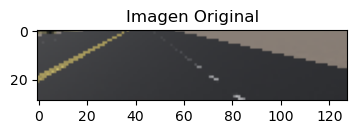

In [17]:
# Cargamos la imagen de prueba
index = random.randrange(0, len(paths))
print(paths[index])
ruta = paths[index]
valor = angles[index]
prueba = np.array(upload_dataset([ruta]))
img_show(ruta, title='Imagen Original')

# Realizamos la predicción con la imagen utilizando la red cargada
prediction = new_model.predict(prueba)[0][0]
print(f'Predicción de la Red: {prediction:.4f} \nControl real: {valor:.4f}')
print(f'Error: {abs(prediction-valor):.4f}')